In [3]:
import sys
sys.path.append("..")

from src.usecase.consolidate_feats_and_annot import read_tse_bi
from src.usecase.fetch_database import create_df_from_file_pattern
import pandas as pd
import os
import seaborn as sns

In [4]:
DATASET_PATIENT_PATTERN = r"[P][A][T][_][0-9]*"
DATASET_EXAM_PATTERN = r"[E][E][G][_][0-9]*"
ANNOTATION_FILE_PATTERN = "*.tse_bi"

In [5]:
df = create_df_from_file_pattern(
    data_folder_path='../output/ecg_qc-v0_6',
    file_pattern=ANNOTATION_FILE_PATTERN,
    file_label='ecg_qc',
    patient_pattern=DATASET_PATIENT_PATTERN,
    exam_pattern=DATASET_EXAM_PATTERN)
print(df)

                                      ecg_qc_file_path  exam_id patient_id
0    ../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_156_s1...  EEG_156     PAT_12
1    ../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_297_s1...  EEG_297     PAT_12
2    ../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_299_s1...  EEG_299     PAT_12
3    ../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_300_s1...  EEG_300     PAT_12
4    ../output/ecg_qc-v0_6/PAT_17/ecg_qc_EEG_253_s1...  EEG_253     PAT_17
..                                                 ...      ...        ...
402  ../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s5....  EEG_103      PAT_9
403  ../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s6....  EEG_103      PAT_9
404  ../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s7....  EEG_103      PAT_9
405  ../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s8....  EEG_103      PAT_9
406  ../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s9....  EEG_103      PAT_9

[407 rows x 3 columns]


In [6]:
def compute_stats_files(tse_bi_file):
    
    df = read_tse_bi(tse_bi_file)
    df['length'] = df['end'] - df['start']
    total_length = df['length'].sum()
    total_noise = df[df['annotation'] == 'noisy']['length'].sum()
    total_clean = df[df['annotation'] == 'clean']['length'].sum()
    ratio_clean = total_clean / (total_noise + total_clean) 
    small_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds <= 4)].shape[0]
    return total_length, total_noise, total_clean, ratio_clean, small_chunks

In [7]:
for i in df.index:
    total_length, total_noise, total_clean, ratio_clean, small_chunks = compute_stats_files(df.loc[i, 'ecg_qc_file_path'])
    df.loc[i, 'total_length'] = total_length
    df.loc[i, 'total_noise'] = total_noise
    df.loc[i, 'total_clean'] = total_clean
    df.loc[i, 'ratio_clean'] = ratio_clean
    df.loc[i, 'small_chunks'] = small_chunks
    
df[['total_length', 'total_noise', 'total_clean']].fillna(pd.Timedelta(seconds=0))
df[['ratio_clean', 'small_chunks']].fillna(0)
df['ratio_small_chunks'] = df['small_chunks']*4 / df['total_length'].dt.seconds
df.head()

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,ratio_clean,small_chunks,ratio_small_chunks
0,../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_156_s1...,EEG_156,PAT_12,0 days 00:19:00,0 days 00:00:54,0 days 00:18:06,0.952632,10.0,0.035088
1,../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_297_s1...,EEG_297,PAT_12,0 days 00:05:44,0 days 00:00:18,0 days 00:05:26,0.947674,5.0,0.058140
2,../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_299_s1...,EEG_299,PAT_12,0 days 00:02:10,0 days 00:02:08,0 days 00:00:02,0.015385,0.0,0.000000
3,../output/ecg_qc-v0_6/PAT_12/ecg_qc_EEG_300_s1...,EEG_300,PAT_12,0 days 00:33:32,0 days 00:33:28,0 days 00:00:04,0.001988,0.0,0.000000
4,../output/ecg_qc-v0_6/PAT_17/ecg_qc_EEG_253_s1...,EEG_253,PAT_17,0 days 02:00:00,0 days 01:56:14,0 days 00:03:46,0.031389,21.0,0.011667


In [8]:
# Top noisy

df.sort_values('ratio_clean', ascending=False)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,ratio_clean,small_chunks,ratio_small_chunks
397,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s28...,EEG_103,PAT_9,0 days 00:51:46,0 days 00:00:06,0 days 00:51:40,0.998068,2.0,0.002576
381,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s13...,EEG_103,PAT_9,0 days 00:04:00,0 days 00:00:02,0 days 00:03:58,0.991667,1.0,0.016667
391,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s22...,EEG_103,PAT_9,0 days 00:07:18,0 days 00:00:04,0 days 00:07:14,0.990868,2.0,0.018265
404,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s7....,EEG_103,PAT_9,0 days 00:03:36,0 days 00:00:02,0 days 00:03:34,0.990741,1.0,0.018519
383,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s15...,EEG_103,PAT_9,0 days 00:03:18,0 days 00:00:02,0 days 00:03:16,0.989899,1.0,0.020202
...,...,...,...,...,...,...,...,...,...
394,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s25...,EEG_103,PAT_9,0 days 00:00:44,NaT,0 days 00:00:44,NaN,0.0,0.000000
400,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s3....,EEG_103,PAT_9,0 days 00:04:58,NaT,0 days 00:04:58,NaN,0.0,0.000000
401,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s4....,EEG_103,PAT_9,0 days 00:00:32,NaT,0 days 00:00:32,NaN,0.0,0.000000
402,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s5....,EEG_103,PAT_9,0 days 00:03:34,NaT,0 days 00:03:34,NaN,0.0,0.000000


In [9]:
# Top clean
df.sort_values('ratio_clean', ascending=True)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,ratio_clean,small_chunks,ratio_small_chunks
242,../output/ecg_qc-v0_6/PAT_52/ecg_qc_EEG_714_s6...,EEG_714,PAT_52,0 days 05:27:00,0 days 05:26:44,0 days 00:00:16,0.000815,1.0,0.000204
335,../output/ecg_qc-v0_6/PAT_6/ecg_qc_EEG_35_s1.t...,EEG_35,PAT_6,0 days 00:32:02,0 days 00:32:00,0 days 00:00:02,0.001041,0.0,0.000000
263,../output/ecg_qc-v0_6/PAT_52/ecg_qc_EEG_717_s1...,EEG_717,PAT_52,0 days 00:24:40,0 days 00:24:38,0 days 00:00:02,0.001351,0.0,0.000000
286,../output/ecg_qc-v0_6/PAT_52/ecg_qc_EEG_706_s2...,EEG_706,PAT_52,0 days 00:45:34,0 days 00:45:30,0 days 00:00:04,0.001463,0.0,0.000000
88,../output/ecg_qc-v0_6/PAT_42/ecg_qc_EEG_568_s1...,EEG_568,PAT_42,0 days 00:22:38,0 days 00:22:36,0 days 00:00:02,0.001473,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
394,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s25...,EEG_103,PAT_9,0 days 00:00:44,NaT,0 days 00:00:44,NaN,0.0,0.000000
400,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s3....,EEG_103,PAT_9,0 days 00:04:58,NaT,0 days 00:04:58,NaN,0.0,0.000000
401,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s4....,EEG_103,PAT_9,0 days 00:00:32,NaT,0 days 00:00:32,NaN,0.0,0.000000
402,../output/ecg_qc-v0_6/PAT_9/ecg_qc_EEG_103_s5....,EEG_103,PAT_9,0 days 00:03:34,NaT,0 days 00:03:34,NaN,0.0,0.000000


In [10]:
# Ratio clean/noise
df['total_clean'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.3185672087432875

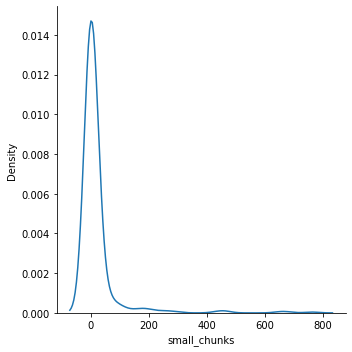

In [11]:
# Small chunks are scarse
sns.displot(df['small_chunks'], kind='kde')

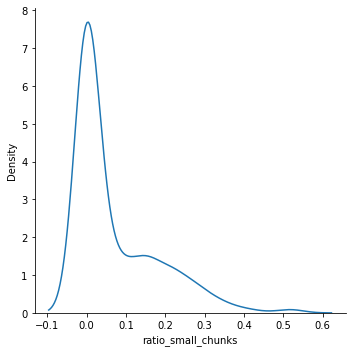

In [12]:
# Small chunks are scarse
sns.displot(df['ratio_small_chunks'], kind='kde')

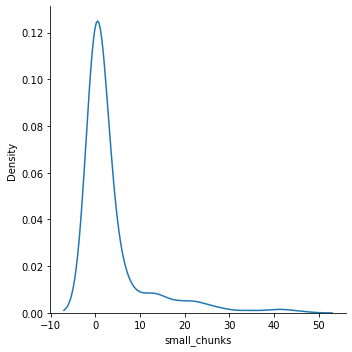

In [13]:
# They are quite rare
sns.displot(df[df['small_chunks'] <= 50]['small_chunks'], kind='kde')

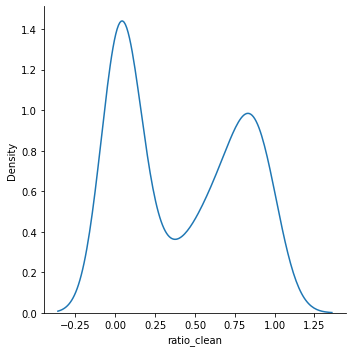

In [14]:
sns.displot(df['ratio_clean'], kind='kde')

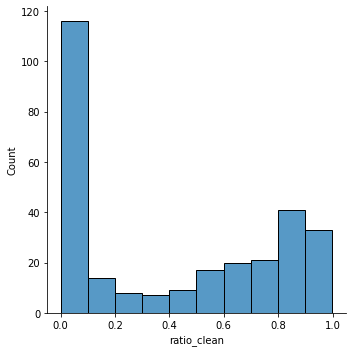

In [15]:
sns.displot(df['ratio_clean'])

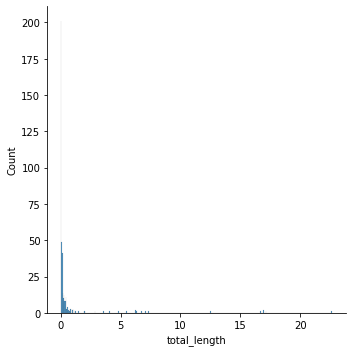

In [16]:
sns.displot(df['total_length'].dt.seconds/3600)

In [17]:
# with good quality
(df[df['ratio_clean'] > 0.5]).shape[0] / df.shape[0]

0.32186732186732187

In [18]:
# % for goog quality length
df[df['ratio_clean'] > 0.5]['total_length'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.384051013968929